# 1. 필요한 module import

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

%matplotlib inline

batch_size = 64
learning_rate = 1e-3
epochs = 10

## CIFAR10 dataset download

- 이름에서 알 수 있듯이 10개의 class가 있다.

In [11]:
cifar_train = dsets.CIFAR10(root="CIFAR10/",
                            train=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                # data augmentation
                                transforms.Scale(36),
                                transforms.CenterCrop(32),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(90),
                                # data normalization
                                transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
                            ]),
                            target_transform=None,
                            download=True)

cifar_test  = dsets.CIFAR10(root="CIFAR10/",
                          train=False,
                          transform=transforms.Compose([
                                transforms.ToTensor(),
                                # data augmentation
                                # test set에서는 data augmentation을 하지 않는다
                                # transforms.Scale(36),
                                # transforms.CenterCrop(32),
                                # transforms.RandomHorizontalFlip(),
                                # transforms.Lambda(lambda x: x.rotate(90)),
                                # data normalization
                                transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
                            ]),
                          target_transform=None,
                          download=True)

Files already downloaded and verified
Files already downloaded and verified


# 2. 대략적인 데이터 형태

cifar_train 길이 : 50000
cifar_test  길이 : 10000
image data 형태 : torch.Size([3, 32, 32])
label           : 9


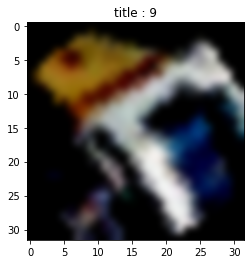

In [12]:
print(f'cifar_train 길이 : {len(cifar_train)}')
print(f'cifar_test  길이 : {len(cifar_test)}')

# 데이터 하나의 형태
img, label = cifar_train.__getitem__(1)
print(f'image data 형태 : {img.shape}')
print(f'label           : {label}')

# 그리기
img = img.numpy()
r, g, b = img[0,:,:], img[1,:,:], img[2,:,:]

img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r, g, b

plt.title(f'title : {label}')
plt.imshow(img2, interpolation='bicubic')
plt.show()

## accuracy 계산 함수

In [13]:
def compute_acc(dloader=None, model=None):
    correct = 0
    total = 0

    for i, [imgs, labels] in enumerate(dloader):
        img = Variable(imgs, requires_grad=False).cuda()
        label = Variable(labels).cuda()

        output = model(img)
        _, output_index = torch.max(output, 1)

        total += label.size(0)
        correct += (output_index == label).sum().float()

    print(f'Accuracy of Test Data: {100 * correct/total}')

# 3. dataloader

In [14]:
train_loader = DataLoader(dataset=cifar_train,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          drop_last=True)
test_loader  = DataLoader(dataset=cifar_test,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=4,
                          drop_last=True)

# 4. model 선언

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(num_features=16),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(num_features=32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm2d(num_features=64),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 100),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10)
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)
                # m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                # m.bias.fill_(0)

    def forward(self, x):
        x = self.layer(x)
        x = self.fc_layer(x)

        return x

model = CNN().cuda()

<ipython-input-17-652f38837485>:32: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)
<ipython-input-17-652f38837485>:35: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight.data)


# 5. loss, optimizer

In [18]:
loss_fn = nn.CrossEntropyLoss().cuda()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# (6) Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# (7) learning rate decay
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)
# 20번 마다

# 6. train

In [19]:
# from tqdm import tqdm

for epoch in range(epochs):
    for img, label in train_loader:
        x = Variable(img).cuda()
        y = Variable(label).cuda()

        optimizer.zero_grad()

        output = model.forward(x)
        loss = loss_fn(output, y)

        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f'epoch: {epoch:3d}  loss: {loss:4f}')

compute_acc(test_loader, model=model)

epoch:   0  loss: 1.485069
epoch:   1  loss: 1.575788
epoch:   2  loss: 1.532889
epoch:   3  loss: 1.628889
epoch:   4  loss: 1.592602
epoch:   5  loss: 1.456454
epoch:   6  loss: 1.600909
epoch:   7  loss: 1.599908
epoch:   8  loss: 1.631031
epoch:   9  loss: 1.091103
Accuracy of Test Data: 49.67948913574219


### 결과

1. drop out (X), batch normalize (X)<br>
    epoch:   0  loss: 1.586255<br>
    epoch:   1  loss: 1.409638<br>
    epoch:   2  loss: 1.371425<br>
    epoch:   3  loss: 1.393552<br>
    epoch:   4  loss: 1.256198<br>
    epoch:   5  loss: 1.234666<br>
    epoch:   6  loss: 1.278961<br>
    epoch:   7  loss: 1.400199<br>
    epoch:   8  loss: 1.071448<br>
    epoch:   9  loss: 1.075819<br>
    Accuracy of Test Data: 60.40665054321289<br>

2. drop out (O), batch normalization(X) : validation할 때는 drop out 풀어줘야해<br>
epoch:   0  loss: 0.989896<br>
epoch:   1  loss: 1.037931<br>
epoch:   2  loss: 0.982638<br>
epoch:   3  loss: 0.945996<br>
epoch:   4  loss: 1.011045<br>
epoch:   5  loss: 0.924622<br>
epoch:   6  loss: 0.974715<br>
epoch:   7  loss: 1.171645<br>
epoch:   8  loss: 0.735848<br>
epoch:   9  loss: 0.915834<br>
Accuracy of Test Data: 65.83533477783203<br>

3. drop out (X), batch normalization(O)<br>
epoch:   0  loss: 0.891396<br>
epoch:   1  loss: 0.799208<br>
epoch:   2  loss: 0.875457<br>
epoch:   3  loss: 0.774157<br>
epoch:   4  loss: 0.824713<br>
epoch:   5  loss: 0.887893<br>
epoch:   6  loss: 0.702824<br>
epoch:   7  loss: 0.946802<br>
epoch:   8  loss: 0.802803<br>
epoch:   9  loss: 0.882120<br>
Accuracy of Test Data: 68.59976196289062<br>

4. drop out (O), batch normalization(O)<br>
epoch:   0  loss: 1.547596<br>
epoch:   1  loss: 1.087219<br>
epoch:   2  loss: 1.041694<br>
epoch:   3  loss: 1.087131<br>
epoch:   4  loss: 1.110288<br>
epoch:   5  loss: 0.794505<br>
epoch:   6  loss: 0.894957<br>
epoch:   7  loss: 0.964484<br>
epoch:   8  loss: 0.809717<br>
epoch:   9  loss: 0.764351<br>
Accuracy of Test Data: 67.24759674072266<br>
?<br>

5. initialization, drop out (X), batch normalizaion(O)<br>
epoch:   0  loss: 0.438303<br>
epoch:   1  loss: 0.664368<br>
epoch:   2  loss: 0.613484<br>
epoch:   3  loss: 0.676378<br>
epoch:   4  loss: 0.496020<br>
epoch:   5  loss: 0.796635<br>
epoch:   6  loss: 0.605567<br>
epoch:   7  loss: 0.561506<br>
epoch:   8  loss: 0.409239<br>
epoch:   9  loss: 0.672561<br>
Accuracy of Test Data: 67.03726196289062<br>